# Курсовой проект

### Постановка задачи

1. (упрощенное/для тех, у кого нет вебкамеры) Нужно написать приложение, которое будет получать на вход изображения. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
2. (более сложное) Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.

In [44]:
# Loading libraries ...

import numpy as np
import pandas as pd

from glob import glob
import sys, os

import PIL
from PIL import Image
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import tqdm


### 1. Загрузка и подготовка данных

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
images = glob('/content/drive/MyDrive/leapGestRecog/leapGestRecog/**/**/*.png')

In [47]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images] # отнимаем 1, чтобы были классы с 0

images[:5], labels[:5]

(['/content/drive/MyDrive/leapGestRecog/leapGestRecog/05/01_palm/frame_05_01_0063.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/05/01_palm/frame_05_01_0019.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/05/01_palm/frame_05_01_0023.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/05/01_palm/frame_05_01_0058.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/05/01_palm/frame_05_01_0038.png'],
 [0, 0, 0, 0, 0])

In [48]:
len(images)

20000

In [49]:
class_nums_names = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
nums_names_classes = {}
for num, name in class_nums_names:
    if num not in nums_names_classes.keys():
        nums_names_classes[num] = name
        
sorted(nums_names_classes.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [50]:
# Функция для перевода номера класса в наименование

def num_to_classname(num):
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [51]:
# Разделение на тренировочную и валидационную выборки
test_size = 0.3
random_state = 1

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=test_size, random_state=random_state)

(240, 640)


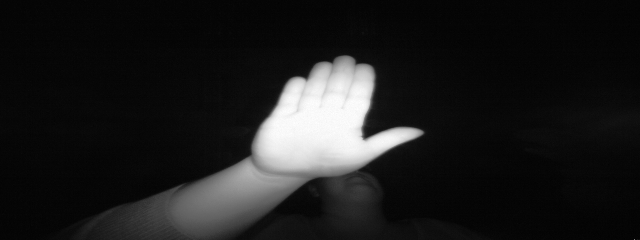

In [52]:
img = Image.open(images[3])
print(np.array(img).shape)
img

Очевидно, картинка растянута по оси х, при трансформации необходимо будет привести размер к оптимальному квадратному.

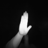

In [53]:
# testing size

img.resize((48,48))

Преобразование в Dataset и Dataloader

In [54]:
class GestureDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):      
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx]) 
        img = self.transformer(img)
#         img = torch.as_tensor(img) # - это включено в трансформацию
        
        return img, self.labels[idx]

In [55]:
train_transformer = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         transforms.RandomRotation(30),               # Случайные повороты на 30 градусов
                        #  transforms.Resize((64,64)),
                        #  transforms.CenterCrop((48, 48)),           # Вырезка фрагмента из центра
                         transforms.ToTensor()]) 

val_transformer =  transforms.Compose([  
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()]) 

In [56]:
batch_size = 256

# Make datasets
train_dataset = GestureDataset(X_train, y_train, train_transformer)
val_dataset = GestureDataset(X_val, y_val, val_transformer)

# Make dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

Класс: 2 - fist
torch.Size([1, 48, 48])


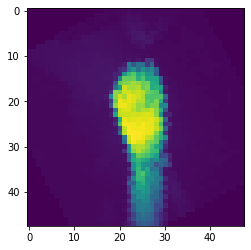

Класс: 7 - palm_moved
torch.Size([1, 48, 48])


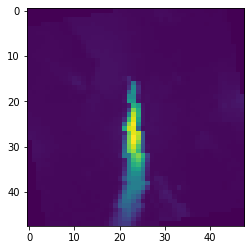

Класс: 6 - ok
torch.Size([1, 48, 48])


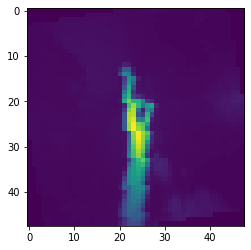

Класс: 5 - index
torch.Size([1, 48, 48])


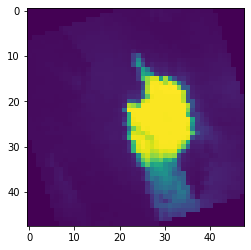

Класс: 3 - fist_moved
torch.Size([1, 48, 48])


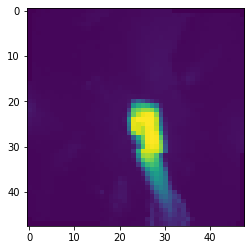

Класс: 2 - fist
torch.Size([1, 48, 48])


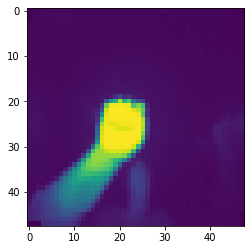

Класс: 0 - palm
torch.Size([1, 48, 48])


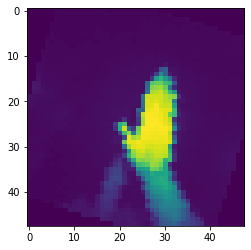

In [57]:
for i, data in enumerate(train_loader):
    print(f'Класс: {data[1][i]} - {num_to_classname(data[1][i])}')
    print(data[0][i].shape)
    plt.imshow(data[0][i].permute(1,2,0).squeeze())
    plt.show()
    if i>5:
        break

image: torch.Size([1, 48, 48])


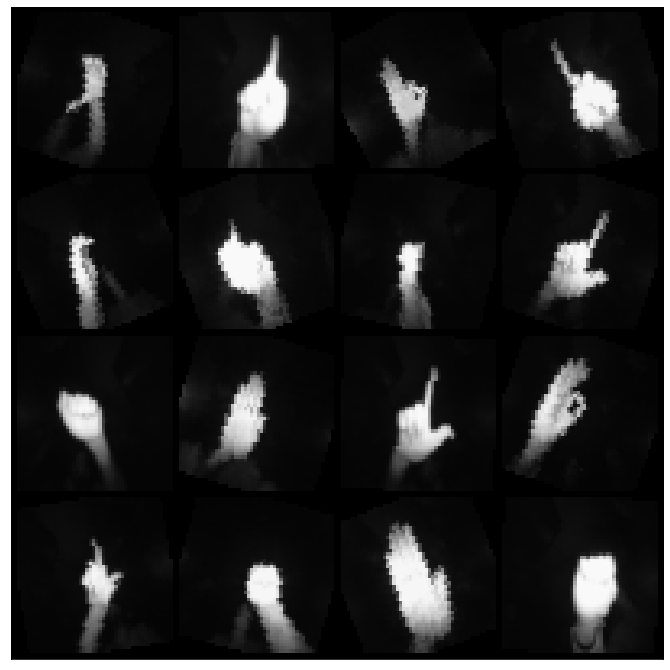

In [58]:
# просмотр батча случайных картинок датасета
def show_batch(train_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader) 

### Модель для классификации жестов (изображений)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [60]:
# Блок конволюционных слоев
def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

# Блок линейных слоев
def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)


#  Сеть
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Конволюционная часть сети
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        
        self.max_pool = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()
        
        self.ff1 = linear_block(512, 256, activation = True)
        self.ff2 = linear_block(256, 128, activation = True)
        self.classifier = linear_block(128, num_classes)
        
    def forward(self, xb):
        #Convolution layers
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) 
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.max_pool(out)
        out = self.flatten(out)
        
        # Feed Forward layers
        out = self.ff1(out)
        out = self.ff2(out)
        out = self.classifier(out)
        
        return out

In [65]:
# Инициализация и компиляция модели

net = ResNet(1, len(nums_names_classes)).to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

Real gesture: (0, 'palm'), Predicted gesture: (7, 'palm_moved')


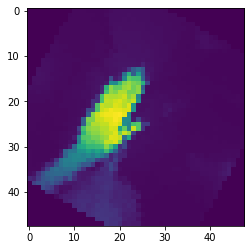

In [62]:
for i, (img, label) in enumerate(train_loader):
    output = net(img[i][None].to(device))
    print(f'Real gesture: {int(label[i]), num_to_classname(int(label[i]))}, '
          f'Predicted gesture: {int(output.argmax(1)), num_to_classname(int(output.argmax(1)))}')
    plt.imshow(img[i].permute(1,2,0).squeeze())
    break

In [66]:
# Обучение сети

epochs = 15

epoch_losses = []

for epoch in range(epochs):
    
    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(data)
        loss = criterion(outputs, labels)
        
        train_running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc
        
        loss.backward()
        optimizer.step()
        
        
    val_running_loss, total_acc_val = 0.0, 0.0
    val_epoch_loss = []
    for data, labels in val_loader:
        net.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = net(data)
        loss = criterion(outputs, labels)
                
        val_running_loss += loss.item()
        val_epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_val += acc
        
    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Val loss:, {np.mean(val_epoch_loss)}, Val acc: {total_acc_val / len(val_dataset):.3f}')
    epoch_losses.append(epoch_loss)
    

100%|██████████| 54/54 [01:26<00:00,  1.61s/it]


Epoch 1, loss:, 2.7060930684760764, Train acc:, 0.162  Val loss:, 2.0738138059775033, Val acc: 0.209


100%|██████████| 54/54 [01:21<00:00,  1.51s/it]


Epoch 2, loss:, 1.9758899300186723, Train acc:, 0.229  Val loss:, 1.8152454793453217, Val acc: 0.310


100%|██████████| 54/54 [01:19<00:00,  1.47s/it]


Epoch 3, loss:, 1.7807420668778595, Train acc:, 0.317  Val loss:, 1.6577147940794628, Val acc: 0.354


100%|██████████| 54/54 [01:19<00:00,  1.46s/it]


Epoch 4, loss:, 1.6278239731435422, Train acc:, 0.370  Val loss:, 1.6266663173834484, Val acc: 0.415


100%|██████████| 54/54 [01:18<00:00,  1.45s/it]


Epoch 5, loss:, 1.4460025451801441, Train acc:, 0.439  Val loss:, 1.2199663321177165, Val acc: 0.502


100%|██████████| 54/54 [01:18<00:00,  1.45s/it]


Epoch 6, loss:, 1.1132104970790722, Train acc:, 0.561  Val loss:, 0.611155778169632, Val acc: 0.770


100%|██████████| 54/54 [01:19<00:00,  1.47s/it]


Epoch 7, loss:, 0.9926211844991755, Train acc:, 0.625  Val loss:, 0.5119478926062584, Val acc: 0.808


100%|██████████| 54/54 [01:18<00:00,  1.46s/it]


Epoch 8, loss:, 0.5351542560038743, Train acc:, 0.760  Val loss:, 0.5430868628124396, Val acc: 0.778


100%|██████████| 54/54 [01:18<00:00,  1.45s/it]


Epoch 9, loss:, 0.5548303303895173, Train acc:, 0.751  Val loss:, 0.3058349136263132, Val acc: 0.857


100%|██████████| 54/54 [01:22<00:00,  1.52s/it]


Epoch 10, loss:, 0.29203287374090264, Train acc:, 0.871  Val loss:, 0.23893405186633268, Val acc: 0.904


100%|██████████| 54/54 [01:22<00:00,  1.53s/it]


Epoch 11, loss:, 0.20049215653152377, Train acc:, 0.918  Val loss:, 0.027697538568948705, Val acc: 0.995


100%|██████████| 54/54 [01:21<00:00,  1.51s/it]


Epoch 12, loss:, 0.09110007697233448, Train acc:, 0.958  Val loss:, 0.03571758950905254, Val acc: 0.991


100%|██████████| 54/54 [01:18<00:00,  1.45s/it]


Epoch 13, loss:, 0.08170142942280681, Train acc:, 0.962  Val loss:, 0.019860068782387923, Val acc: 0.996


100%|██████████| 54/54 [01:20<00:00,  1.49s/it]


Epoch 14, loss:, 0.051999076933565515, Train acc:, 0.971  Val loss:, 0.023816865170374513, Val acc: 0.996


100%|██████████| 54/54 [01:17<00:00,  1.44s/it]


Epoch 15, loss:, 0.04200774228579744, Train acc:, 0.975  Val loss:, 0.03466946150486668, Val acc: 0.989


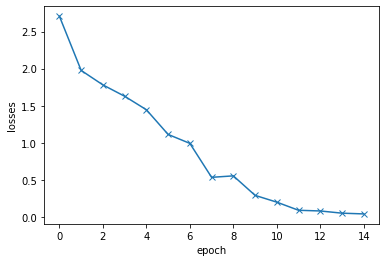

In [67]:
#график функции ошибок по эпохам
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [68]:
# Save model

torch.save(net, './gesture_classification_model_1ver.pth')

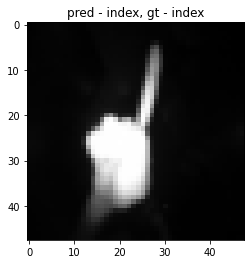

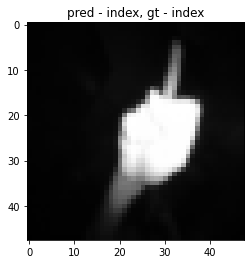

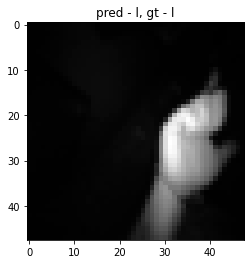

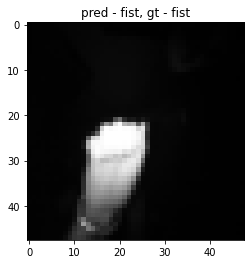

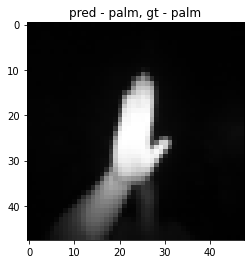

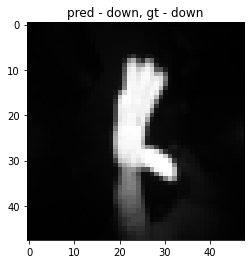

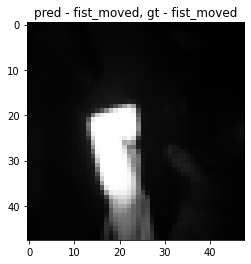

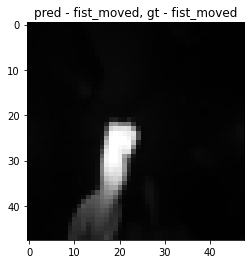

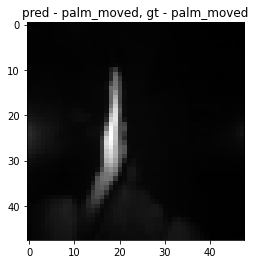

In [69]:
# Load model, test prediction

net = torch.load('./gesture_classification_model_1ver.pth')
# net.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

Создана модель для классификации жестов, далее необходимо ее сочетать с моделью распознавания лиц.